# Implémentation & Test de Dream-MCMC avec sous-échantillonnage

In [1]:
from core_2_models_gelman import*

In [2]:
priors_couche_1 = {
    "moinslog10K": ((1, 10), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

priors_couche_2 = {
    "moinslog10K": ((4, 9), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

priors_couche_3 = {
    "moinslog10K": ((3, 8), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

all_priors = [
    ['Couche 1', 0.2, priors_couche_1],
    ['Couche 2', 0.3, priors_couche_2],
    ['Couche 3', 0.4, priors_couche_3]
]

if not isinstance(all_priors, AllPriors):
    all_priors = AllPriors([LayerPriors(*conv(layer)) for layer in all_priors])


nb_burnin_list1 = []
nb_burnin_list2 = []

## Tests

In [3]:
import pandas as pd
PARAM_LIST = ("moinslog10K", "n", "lambda_s", "rhos_cs")

capteur_riviere = pd.read_csv("../data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("../data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + 273.15
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + 273.15

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

'''params = Param(
    moinslog10K = 7,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

params_tuple = (7, .1, 2, 4e6)

assert params == params_tuple
print('params = ',params)
col.compute_solve_transi(params, nb_cells=100)'''

"params = Param(\n    moinslog10K = 7,\n    n = .1,\n    lambda_s = 2,\n    rhos_cs = 4e6\n)\n\nparams_tuple = (7, .1, 2, 4e6)\n\nassert params == params_tuple\nprint('params = ',params)\ncol.compute_solve_transi(params, nb_cells=100)"

Exécution de dream_mcmc sur l'objet Column

In [4]:
nb_chain = 10
nb_iter = 1000
nb_param = 4
nb_cells = 100
threshold = 1.1


col.compute_dream_mcmc_without_sigma2(
    nb_iter,
    all_priors,
    nb_cells,
    nb_chain=nb_chain,
    verbose=True
)

--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 4 et 9, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 3 et 8, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
Number of cells : 100
Number of iterations : 1000
Number of chains : 10
--------------------


c:\Users\Thinkpad\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'list_zLow' of function 'compute_H_stratified'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "utils.py", line 476:
@njit
def compute_H_stratified(array_K, array_Ss, list_zLow, z_solve, inter_cara, moinslog10K_list, Ss_list, all_dt, isdtconstant, dz, H_init, H_riv, H_aq, alpha=ALPHA):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Initialisation - Utilisation de la mémoire (en Mo) : 257.163264
--- Begin Burn in phase ---


c:\Users\Thinkpad\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'list_zLow' of function 'compute_H_stratified'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "utils.py", line 476:
@njit
def compute_H_stratified(array_K, array_Ss, list_zLow, z_solve, inter_cara, moinslog10K_list, Ss_list, all_dt, isdtconstant, dz, H_init, H_riv, H_aq, alpha=ALPHA):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Burn in finished after : 124 iterations by gelman rubin
Burn in finished after : 201 iterations by modified gelman rubin
Both 2 model reach burn in
Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 296.067072
DREAM MCMC Computation: 100%|██████████| 1000/1000 [02:44<00:00,  6.06it/s]
Occupation mémoire des températures (en Mo) :  528.836
Occupation mémoire des flux (en Mo) :  528.836
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 1343.741952
Quantiles computed
Fin de l'exécution - Utilisation de la mémoire (en Mo) : 1350.127616


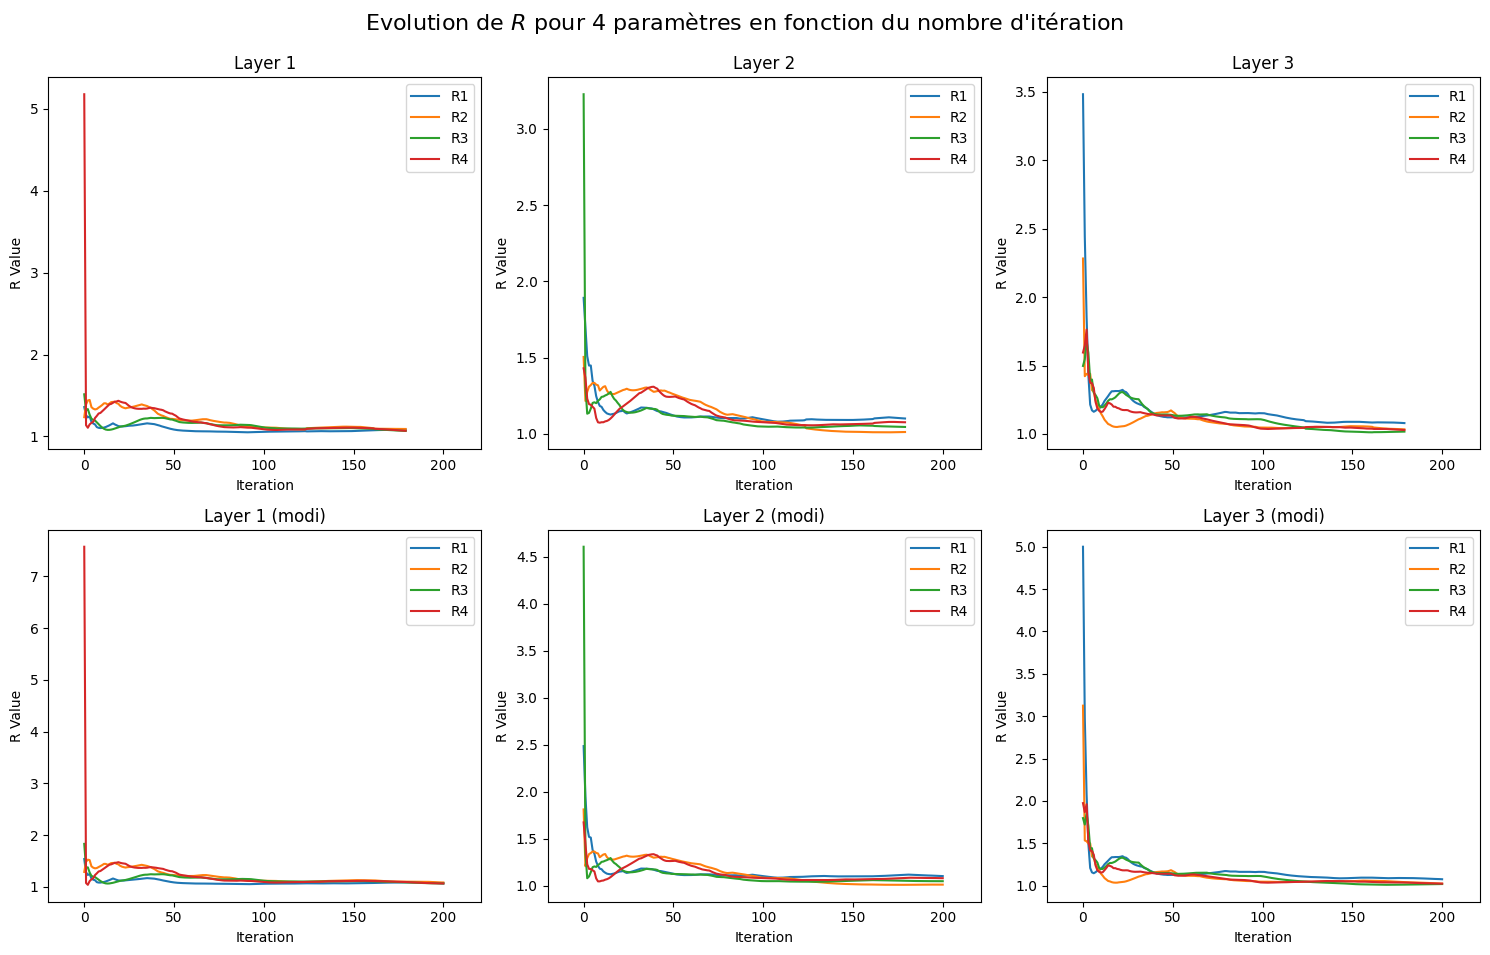

In [7]:

axe_x = max(len(col.R_list),len(col.R_list_modi))
flattened_list1 = np.array(col.R_list).flatten()
flattened_list2 = np.array(col.R_list_modi).flatten()
threshold = 1.1

# 找到展平后列表的最大值
max1= np.max(flattened_list1)
max2 = np.max(flattened_list2)
max_y = max(max1,max2)


n_burn_in = len(col.R_list)
x = list(range(n_burn_in))

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for l in range(len(all_priors)):
    ax = axs[0, l]
    ax.set_title(f'Layer {l+1}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('R Value')

    for i in range(len(col.R_list[0][0])):
        R_i = [R[l][i] for R in col.R_list]
        ax.plot(x, R_i, label=f'R{i+1}')
        ax.set_xlim(-axe_x*0.1, axe_x*1.1)
        #ax.set_ylim(0.5, 3)#max_y*1.1)

    ax.legend()


#R_list_modi
n_burn_in_modi = len(col.R_list_modi)
x_modi = list(range(n_burn_in_modi))
for l in range(len(all_priors)):
    ax = axs[1, l]
    ax.set_title(f'Layer {l+1} (modi)')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('R Value')

    for i in range(len(col.R_list_modi[0][0])):
        R_i = [R[l][i] for R in col.R_list_modi]
        ax.plot(x_modi, R_i, label=f'R{i+1}')
        ax.set_xlim(-axe_x*0.1, axe_x*1.1)
        #ax.set_ylim(0.5, 3)#max_y*1.1)

    # 添加图例
    ax.legend()

# 调整布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.suptitle('Evolution de $R$ pour 4 paramètres en fonction du nombre d\'itération',fontsize=16)


# 显示图形

savepath = r'D:\SVN000\Molonari\Quantile projet\mcmc_gelman_images\{}_{}_{}.png'.format(threshold, col.nb_burn_in_iter, col.nb_burn_in_iter_modi)
plt.savefig(savepath)
plt.show()
#plt.savefig('D:\SVN000\Molonari\Quantile projet\gelman_images\f'{threshold}_{nb_burn_in_iter}_{nb_burn_in_iter_modi}'.png') 

In [8]:
nb_burnin_list1.append(n_burn_in)
nb_burnin_list2.append(n_burn_in_modi)

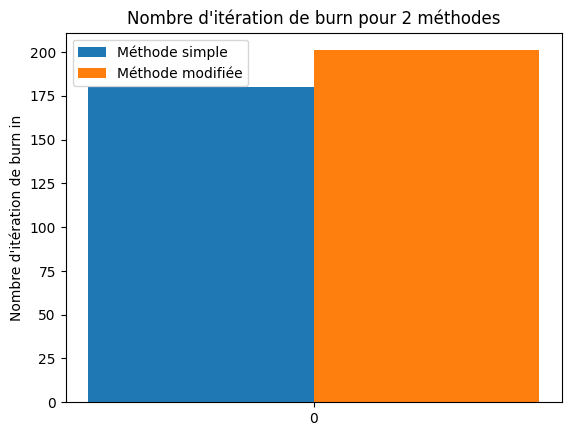

In [10]:

# 示例数据
positions = np.arange(len(nb_burnin_list1))  # 生成位置数组

# 绘制柱状图
width = 0.35  # 设置柱状图的宽度
fig, ax = plt.subplots()

rects1 = ax.bar(positions - width/2, nb_burnin_list1, width, label='Méthode simple')
rects2 = ax.bar(positions + width/2, nb_burnin_list2, width, label='Méthode modifiée')

# 添加标签、标题等
#ax.set_xlabel('位置')
ax.set_ylabel('Nombre d\'itération de burn in')
ax.set_title('Nombre d\'itération de burn pour 2 méthodes')
ax.set_xticks(positions)
ax.set_xticklabels([str(i) for i in positions])
ax.legend()

# 显示图形
plt.show()

## Histogrammes

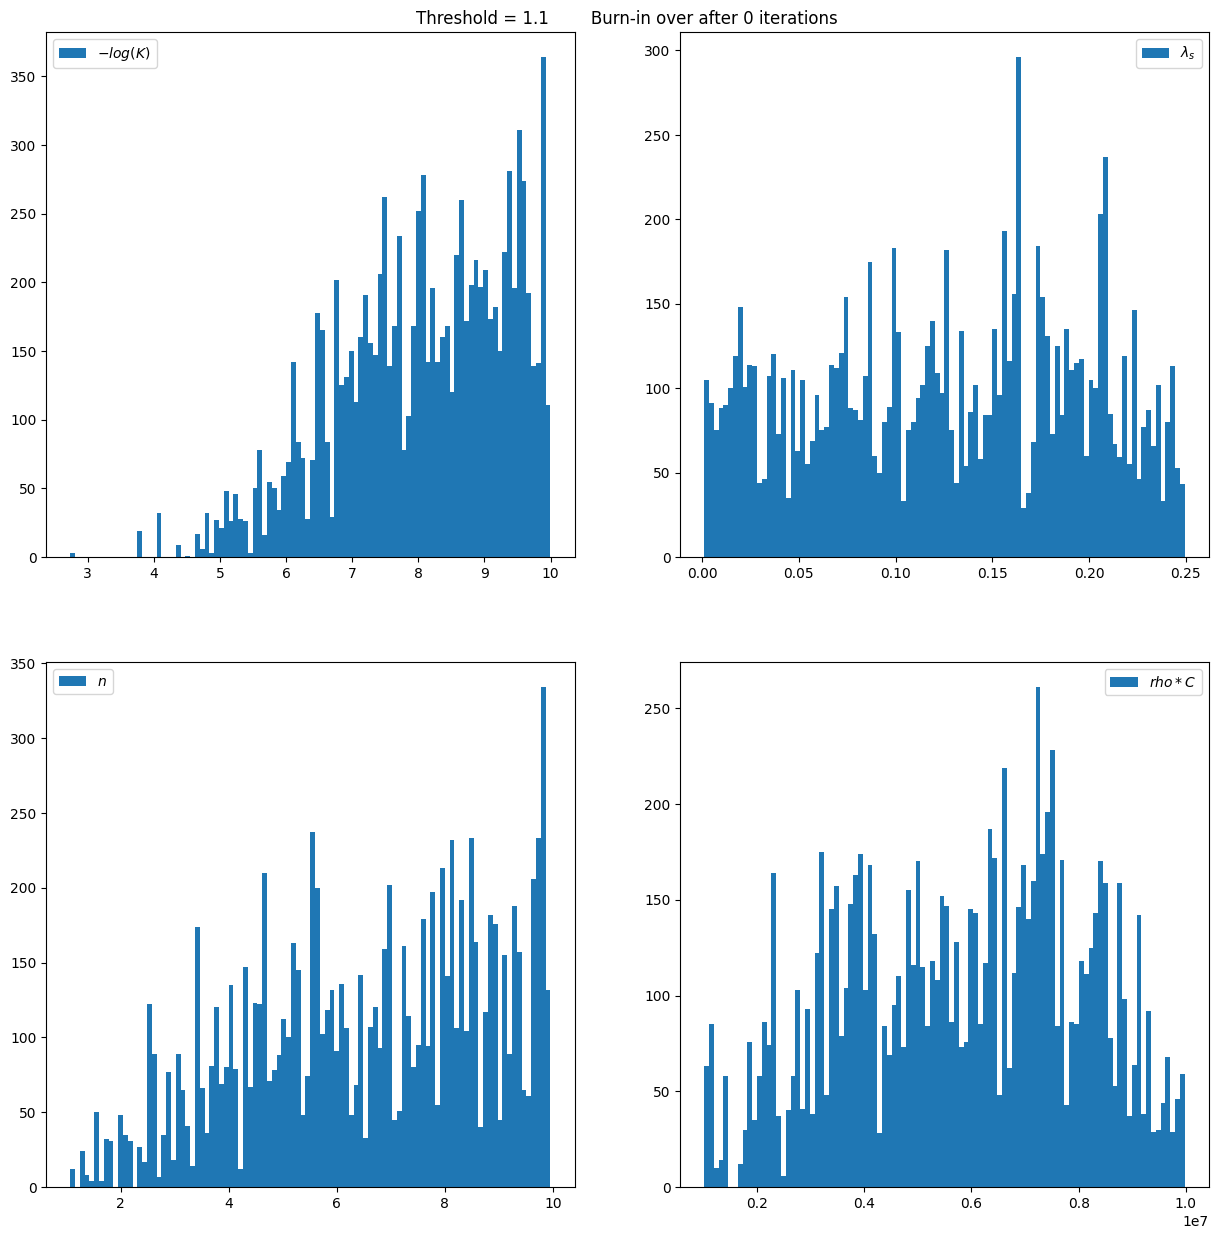

In [ ]:
_params = np.array([col._states[k].layers[0].params for k in range(len(col._states))])
threshold = 1.1

plt.figure(figsize=(15,15))
plt.title(f"Threshold = {threshold}        Burn-in over after {0} iterations")
plt.axis('off')
dico = {0 : "$-log(K)$", 1 : "$\lambda_s$", 2 : "$n$", 3 : "$rho * C$"}
for k in range(nb_param):
    plt.subplot(2, 2, k+1)
    plt.hist(_params[:,k], bins = 100, label=f"{dico[k]}")
    plt.legend();
plt.savefig(f"../images/threshold_{int(threshold*100)}.png")

In [ ]:
_params.nbytes

160160

In [ ]:
col._quantiles_flows[0.5].nbytes

1047200

In [ ]:
print(np.zeros((nb_iter+1, nb_chain, 25, 655)).nbytes / 1000000000, "Go")

1.31131 Go
